In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=sk-替换为自己的API Key

%env JINA_SEGMENT_API_KEY=jina_替换为自己的API Key

In [2]:
%%capture --no-stderr
!pip install -U langchain langchain-community langchain-experimental langchain-openai pypdf sentence_transformers chromadb shutil

In [3]:
import os
import pandas as pd

In [4]:
expr_version = 'split_03_jiner_segment_api'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 读取文档

In [5]:
from langchain_community.document_loaders import PyPDFLoader
import re

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
pdf_documents = loader.load()

# 把页眉页脚去掉
pattern = r"^全球经济金融展望报告\n中国银行研究院 \d+ 2024年"
pdf_document = '\n\n'.join(re.sub(pattern, '', doc.page_content) for doc in pdf_documents)
markdown_document = open(os.path.join(os.path.pardir, 'outputs', 'MinerU_parsed_20241204', '2024全球经济金融展望报告.md')).read()

In [7]:
len(pdf_document)

31202

In [8]:
len(markdown_document)

33940

# 文档切分

In [23]:
import os
import pickle
import requests
from langchain.schema import Document

def split_with_jina_api(text, max_len=700):
    url = 'https://segment.jina.ai/'
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f"Bearer {os.getenv('JINA_SEGMENT_API_KEY')}"
    }
    data = {
        "content": text,
        "return_tokens": True,
        "return_chunks": True,
        "max_chunk_length": max_len
    }
    response = requests.post(url, headers=headers, json=data)
    resp_json = response.json()
    chunks = resp_json['chunks']
    return [Document(page_content=chunk.strip()) for chunk in chunks if chunk.strip() != '']

In [24]:
pdf_splitted_docs = split_with_jina_api(pdf_document)
markdown_splitted_docs = split_with_jina_api(markdown_document)

splitted_docs_dict = {
    'pdf': pdf_splitted_docs,
    'markdown': markdown_splitted_docs
}

## 检查一下切分后的块长度分布

In [27]:
for key, splitted_docs in splitted_docs_dict.items():
    print(f"=============== {key} ===============")
    print(f"docs count: {len(splitted_docs)}")
    print('doc length distribution')
    print(pd.Series([len(d.page_content) for d in splitted_docs]).describe([0.25, 0.5, 0.75, 0.9, 0.97, 0.99]))

=============== pdf ===============
docs count: 964
doc length distribution
count    964.000000
mean      31.262448
std       10.110942
min        1.000000
25%       28.000000
50%       34.000000
75%       37.000000
90%       41.000000
97%       44.110000
99%       47.000000
max       54.000000
dtype: float64
=============== markdown ===============
docs count: 280
doc length distribution
count    280.000000
mean     117.335714
std      135.322745
min        3.000000
25%       20.000000
50%       52.500000
75%      182.750000
90%      332.000000
97%      451.930000
99%      532.050000
max      567.000000
dtype: float64


# 检索

In [28]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

model_path = 'BAAI/bge-large-zh-v1.5'
embeddings = get_embeddings(model_path)

device: cuda


/opt/anaconda3/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [29]:
import jieba
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma

def get_vector_db(splitted_docs, embeddings, name):
    persist_directory = os.path.join(expr_dir, 'chroma', 'bge', name)
    shutil.rmtree(persist_directory, ignore_errors=True)
    vector_db = Chroma.from_documents(
        splitted_docs,
        embedding=embeddings,
        persist_directory=persist_directory
    )
    return vector_db

In [30]:
vector_db_dict = {
    key: get_vector_db(splitted_docs, embeddings, f"{key}_chroma")
    for key, splitted_docs in splitted_docs_dict.items()
}

# 生成答案

In [31]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434',
    top_k=1
)

/tmp/ipykernel_3287872/3342461511.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  ollama_llm = Ollama(


In [32]:
import time

def rag(vector_db, llm, query, n_chunks=4):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()
    chunks = vector_db.similarity_search(query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)
    retry_count = 3

    resp = ''
    while retry_count > 0:
        try:
            resp = llm.invoke(prompt)
            break
        except Exception as e:
            retry_count -= 1
            sleeping_seconds = 2 ** (4 - retry_count)
            print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
            
            time.sleep(sleeping_seconds)
    
    return resp, chunks

## 预测

In [33]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(vector_db, llm, prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(vector_db, llm, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }

    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [34]:
save_path = os.path.join(expr_dir, 'preds.pkl')

In [35]:
if os.path.exists(save_path):
    print(f'found cache at {save_path}')
    pred_dict = pickle.load(open(save_path, 'rb'))
else:
    pred_dict = {}

In [36]:
for key, vector_db in vector_db_dict.items():
    print(f'prediting for {key} ...')
    if key in pred_dict:
        continue
    pred_df = predict(vector_db, ollama_llm, prediction_df, n_chunks=3)
    pred_dict[key] = pred_df
    pickle.dump(pred_dict, open(save_path, 'wb'))

prediting for pdf ...


  0%|          | 0/100 [00:00<?, ?it/s]

prediting for markdown ...


  0%|          | 0/100 [00:00<?, ?it/s]

# 评估

In [37]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={question}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [38]:
eval_save_path = os.path.join(expr_dir, 'evals.pkl')

In [39]:
if os.path.exists(eval_save_path):
    print(f"found cache at {eval_save_path}")
    eval_dict = pickle.load(open(eval_save_path, 'rb'))
else:
    eval_dict = {}

In [40]:
metrics = []

for key, vector_db in vector_db_dict.items():
    print(f'evaluating for {key} ...')
    if key in eval_dict:
        pred_df = eval_dict[key]
    else:
        pred_df = pred_dict[key]
        pred_df['raw_score'] = evaluate(pred_df)
        eval_dict[key] = pred_df
        pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)
        
    print(f"key={key} raw_score unique: {pred_df['raw_score'].unique()}, accuracy={pred_df['score'].mean()}")
    metrics.append({
        'key': key,
        'accuracy': pred_df['score'].mean()
    })
    pickle.dump(eval_dict, open(eval_save_path, 'wb'))

evaluating for pdf ...


  0%|          | 0/100 [00:00<?, ?it/s]

key=pdf raw_score unique: ['是' '否'], accuracy=0.53
evaluating for markdown ...


  0%|          | 0/100 [00:00<?, ?it/s]

key=markdown raw_score unique: ['是' '否'], accuracy=0.69


In [41]:
metrics_df = pd.DataFrame(metrics)

In [42]:
metrics_df

,key,accuracy
0,pdf,0.53
1,markdown,0.69


<Axes: xlabel='key', ylabel='accuracy'>

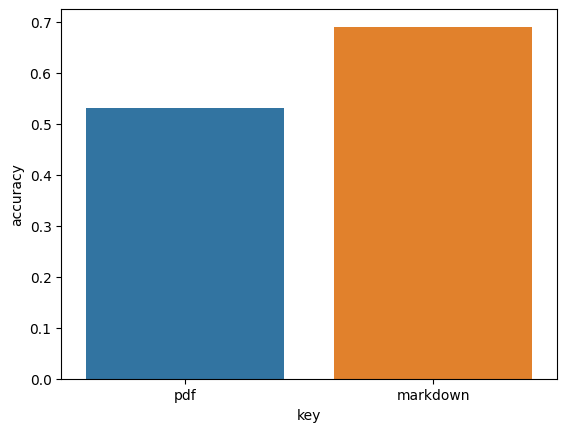

In [43]:
import seaborn as sns

sns.barplot(x='key', y='accuracy', data=metrics_df)